In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Masking, Bidirectional, LSTM, TimeDistributed, Dense, Activation

import warnings
warnings.filterwarnings('ignore')

2023-01-11 16:56:28.830678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 16:56:29.412761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-11 16:56:29.412823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-11 16:56:29.412831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [5]:
BATCH_SIZE = 512
VALIDATION_RATIO = 0.1

PIECE_LEN = 1024
n_feature = 43
n_hidden = 100
n_pitch = 53
learning_rate = 0.001

## build dataset

In [6]:
def load_npy_data(x_path, y_path, offset):
    x = np.load(x_path)
    y = np.load(y_path)
    if x.shape[0] >= offset+PIECE_LEN:
        return x[offset:offset+PIECE_LEN].astype(np.float64), y[offset:offset+PIECE_LEN].astype(np.float64)
    else:
        pad_count = offset + PIECE_LEN - x.shape[0]
        x = np.pad(x[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        y = np.pad(y[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        return x, y

def generate_dataset(input_dir: str):
    x_paths = []
    y_paths = []
    offsets = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith(".ans.npy"):
            y_path = str(os.path.join(input_dir, file_name))
            x_path = str(os.path.join(input_dir, file_name.replace(".ans.npy", ".npy")))
            assert os.path.exists(x_path), f"corresponding input file {x_path} doesn't exist"
            y_content = np.load(y_path)
            for offset in range(0, y_content.shape[0], PIECE_LEN):
                y_paths.append(y_path)
                x_paths.append(x_path)
                offsets.append(offset)

    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths, offsets)).shuffle(100000)
    train_dataset = train_dataset.map(lambda x_path, y_path, offset: tf.numpy_function(load_npy_data, [x_path, y_path, offset], [tf.float64, tf.float64]))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(-1).cache()
    
    return train_dataset

In [7]:
train_dataset = generate_dataset("./preprocessed_dataset/irealpro_dataset_v2_simple/")

## build model

In [8]:
# print("Creating model")
input = tf.keras.Input(shape=(PIECE_LEN, n_feature))  
x = Masking(mask_value=-1, input_shape=(PIECE_LEN, n_feature))(input) # Ignore Padded Data
x = Bidirectional(LSTM(units=n_hidden, input_shape=(1, n_feature), return_sequences=True, ))(x)
x = TimeDistributed(Dense(n_pitch, activation="softmax"))(x)
model = tf.keras.Model(inputs=input, outputs=x)

print(model.summary())

optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=learning_rate, clipvalue=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 43)]        0         
                                                                 
 masking (Masking)           (None, 1024, 43)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1024, 200)        115200    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1024, 53)         10653     
 ibuted)                                                         
                                                                 
Total params: 125,853
Trainable params: 125,853
Non-trainable params: 0
_________________________________________________________________
None


## loss/accuracy function

In [9]:
def masked_loss_function(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    loss = tf.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    acc = tf.metrics.categorical_accuracy(y_true, y_pred)
    mask = tf.cast(mask, acc.dtype)
    acc *= mask
    return tf.reduce_mean(acc)

### restore checkpoint

In [10]:
checkpoint_dir = './checkpoints/BDLSTM_simple_try2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [6]:
checkpoint.restore(checkpoint_prefix+"-2")

## training

In [11]:
@tf.function
def train_step(x, y):
    loss = 0
    with tf.GradientTape() as tape:
        pred = model(x)
        
        loss = masked_loss_function(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = masked_accuracy(y, pred)

    return loss, acc

In [12]:
loss_history = []
# loss_history = np.load("experiments/BDLSTM_simple/history.npy").tolist()
acc_history = []

In [23]:
# set the epochs for training
EPOCHS = 200

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(float(total_loss / steps_per_epoch))
    # acc_history.append(float(total_acc / steps_per_epoch))

Epoch 1 Loss 1.3667 Acc 0.3257
Time taken for 1 epoch 4.437591552734375 sec

Epoch 2 Loss 1.3779 Acc 0.3231
Time taken for 1 epoch 4.374716758728027 sec

Epoch 3 Loss 1.3748 Acc 0.3237
Time taken for 1 epoch 4.40550422668457 sec

Epoch 4 Loss 1.3683 Acc 0.3252
Time taken for 1 epoch 4.410151243209839 sec

Epoch 5 Loss 1.3645 Acc 0.3260
Time taken for 1 epoch 4.420413494110107 sec

Epoch 6 Loss 1.3644 Acc 0.3259
Time taken for 1 epoch 4.428994655609131 sec

Epoch 7 Loss 1.3647 Acc 0.3257
Time taken for 1 epoch 4.37913703918457 sec

Epoch 8 Loss 1.3633 Acc 0.3260
Time taken for 1 epoch 4.411805629730225 sec

Epoch 9 Loss 1.3615 Acc 0.3266
Time taken for 1 epoch 4.427037477493286 sec

Epoch 10 Loss 1.3584 Acc 0.3273
Time taken for 1 epoch 4.419658899307251 sec

Epoch 11 Loss 1.3580 Acc 0.3274
Time taken for 1 epoch 4.422640562057495 sec

Epoch 12 Loss 1.3577 Acc 0.3274
Time taken for 1 epoch 4.408873796463013 sec

Epoch 13 Loss 1.3574 Acc 0.3274
Time taken for 1 epoch 4.403975248336792 se

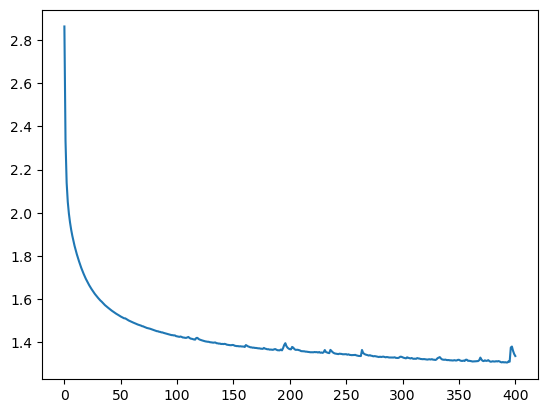

In [24]:
plt.plot(loss_history)

In [25]:
checkpoint.save(checkpoint_prefix)
np.save("experiments/BDLSTM_simple/try2_history.npy", np.array(loss_history))

## predict

In [16]:
def slice_per_step(a):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    original_length = a.shape[0]
    pad_count = PIECE_LEN - (original_length % PIECE_LEN)
    print(a.shape, end=' ')
    if pad_count!=PIECE_LEN : 
        print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)
    # reshape into per step
    a = np.reshape(a, (-1, PIECE_LEN, a.shape[1]))
    print('to',a.shape)
    return a, original_length

In [17]:
import midi_np_translation.output2midi_v2_simple as output2midi

In [18]:
test_file = np.load("preprocessed_dataset/irealpro_dataset_v2_simple/Autumn Leaves_o0.mid.npy")
padded_input, original_length = slice_per_step(test_file)
test_result = np.reshape(model.predict(padded_input), (-1, 53))[:original_length]
print(test_result.shape)
output2midi.output_to_midi(bass_ndarr=test_result, 
                           ref_midi_path="input_midi/irealpro_transposed/Autumn Leaves_o0.mid", 
                           output_path="experiments/BDLSTM_simple/autumn_irealpro.mid")

(1560, 43) pad by 488 to (2, 1024, 43)
1/1 [==============================] - 2s 2s/step
(1560, 53)


In [19]:
test_file = np.load("preprocessed_dataset/dense_jazz/AutumnLeaves_o0.mid.npy")
padded_input, original_length = slice_per_step(test_file)
test_result = np.reshape(model.predict(padded_input), (-1, 53))[:original_length]
output2midi.output_to_midi(bass_ndarr=test_result, 
                           ref_midi_path="input_midi/transpose_augmentation/AutumnLeaves_o0.mid", 
                           output_path="experiments/BDLSTM_simple/autumn_arr.mid")

(1712, 42) pad by 336 to (2, 1024, 42)
1/1 [==============================] - 1s 1s/step


In [20]:
test_file = np.load("preprocessed_dataset/dense_jazz/PieceOfMyWish_p1.mid.npy")
padded_input, original_length = slice_per_step(test_file)
test_result = np.reshape(model.predict(padded_input), (-1, 53))[:original_length]
output2midi.output_to_midi(bass_ndarr=test_result, 
                           ref_midi_path="input_midi/transpose_augmentation/PieceOfMyWish_p1.mid", 
                           output_path="experiments/BDLSTM_simple/PieceOfMyWish.mid")

(1688, 42) pad by 360 to (2, 1024, 42)
1/1 [==============================] - 0s 32ms/step


In [21]:
test_file = np.load("preprocessed_dataset/augmentation/55Dive_o0.mid.npy")
padded_input, original_length = slice_per_step(test_file)
test_result = np.reshape(model.predict(padded_input), (-1, 53))[:original_length]
output2midi.output_to_midi(bass_ndarr=test_result, 
                           ref_midi_path="input_midi/transpose_augmentation/55Dive_o0.mid", 
                           output_path="experiments/BDLSTM_simple/55Dive.mid")

(593, 42) pad by 431 to (1, 1024, 42)
1/1 [==============================] - 0s 22ms/step
